In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet18
import json
import os
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments')

from helpers.train_all_2 import TrainerAll2


from helpers.trainer import Trainer
from helpers.train_all import TrainerAll

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def whitening_transform(data):
    # Center the data (subtract mean)
    mean = torch.mean(data, dim=0, keepdim=True)
    centered_data = data - mean

    # Compute covariance matrix
    covariance_matrix = torch.matmul(centered_data.T, centered_data) / (centered_data.size(0) - 1)

    # Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = torch.eig(covariance_matrix, eigenvectors=True)

    # Whitening transformation
    whitened_data = torch.matmul(torch.matmul(eigenvectors, torch.diag(1 / torch.sqrt(eigenvalues[:, 0]))), eigenvectors.T) @ centered_data.T
    
    return whitened_data.T

In [4]:
# Defining batch size as given on page 7 on Adam Research Paper
batch_size = 128    

# Calculate the number of workers to use for DataLoader
num_workers = 8

# transformations
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments/models')

# Load CIFAR-10 dataset
trainset = datasets.ImageFolder(root='/home/raid/Desktop/Shubh/DLProject/datasets/ImageNet/tiny-imagenet-200/train', transform=transform)
testset = datasets.ImageFolder(root='/home/raid/Desktop/Shubh/DLProject/datasets/ImageNet/tiny-imagenet-200/test', transform=transform)

# trainset = whitening_transform(trainset)
# testset = whitening_transform(testset)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(512, 200)  # Change output size to match CIFAR-10 classes

    def forward(self, x):
        x = self.resnet(x)
        return x

In [7]:
criterion = nn.CrossEntropyLoss()
epochs = 200

optimizer = optim.Adam

In [8]:
model = ResNet().to(device)
trainer = TrainerAll(train_loader, test_loader, criterion, epochs=30)

head1, head2, head3 = 'EPOCHS', 'TRAIN LOSS', 'VAL LOSS'
print(f'{head1 :>6} {head2 :>25} {head3 :>25}')

log = trainer.train_all_optim(model)

/home/raid/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raid/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EPOCHS                TRAIN LOSS                  VAL LOSS
Optimizer : Adam_torch


/home/raid/miniconda3/envs/dl/lib/python3.12/site-packages/torch/autograd/__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1177.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    10        0.2755579198412883        18.704735285119167
    20       0.10156562972499435        19.959227067005784
    30       0.06562317425832914        22.428861956053144
Optimizer : RMS_torch
    10       0.40379907106956864        14.355115540419952
    20         0.108746983670651        24.593774747244918
    30       0.06763087752360918         21.41023469273048
Optimizer : AdaGrad_torch
    10        1.1991835068863677         8.599902877324745
    20       0.22471627330078797         8.889621203458763
    30        0.0851699134234882         9.121110348761837


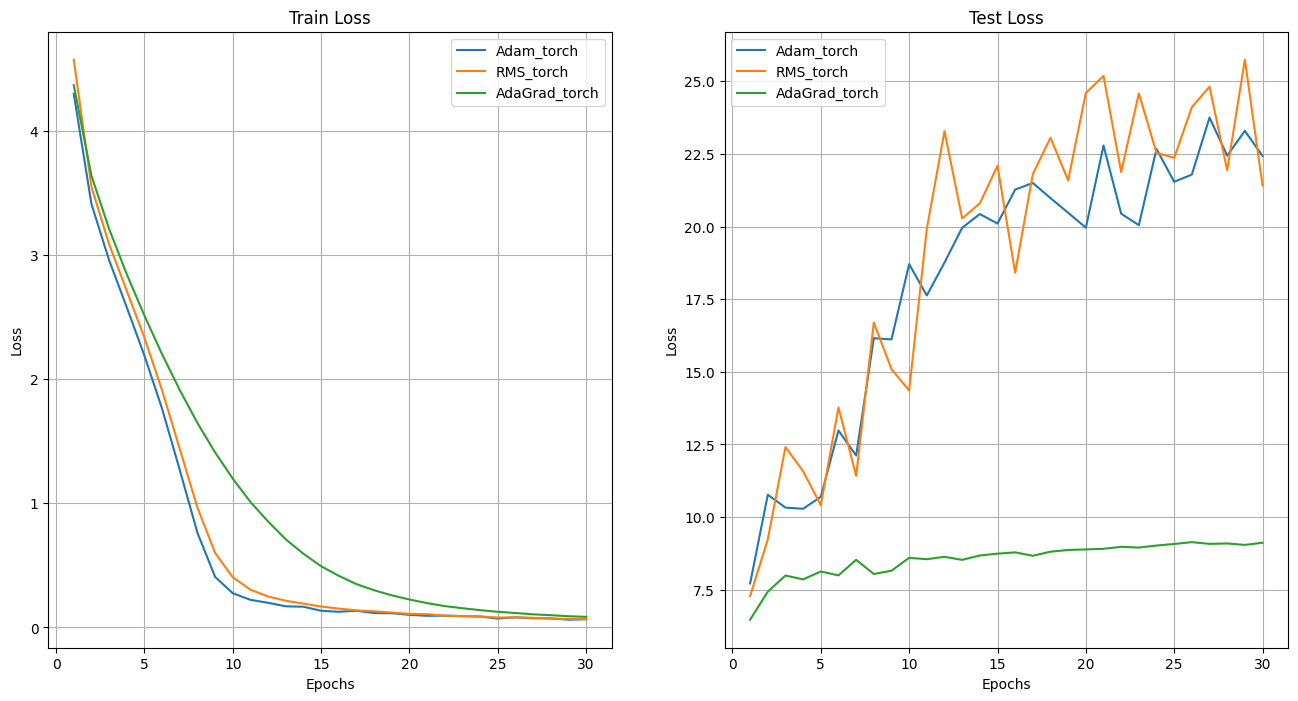

In [12]:
trainer.plot_loss_graphs()

In [10]:
# import json

# with open('../results/logs/CIFAR_CNN.json', 'w', encoding ='utf8') as file: 
#     json.dump(log, file, ensure_ascii = False, indent=4) 

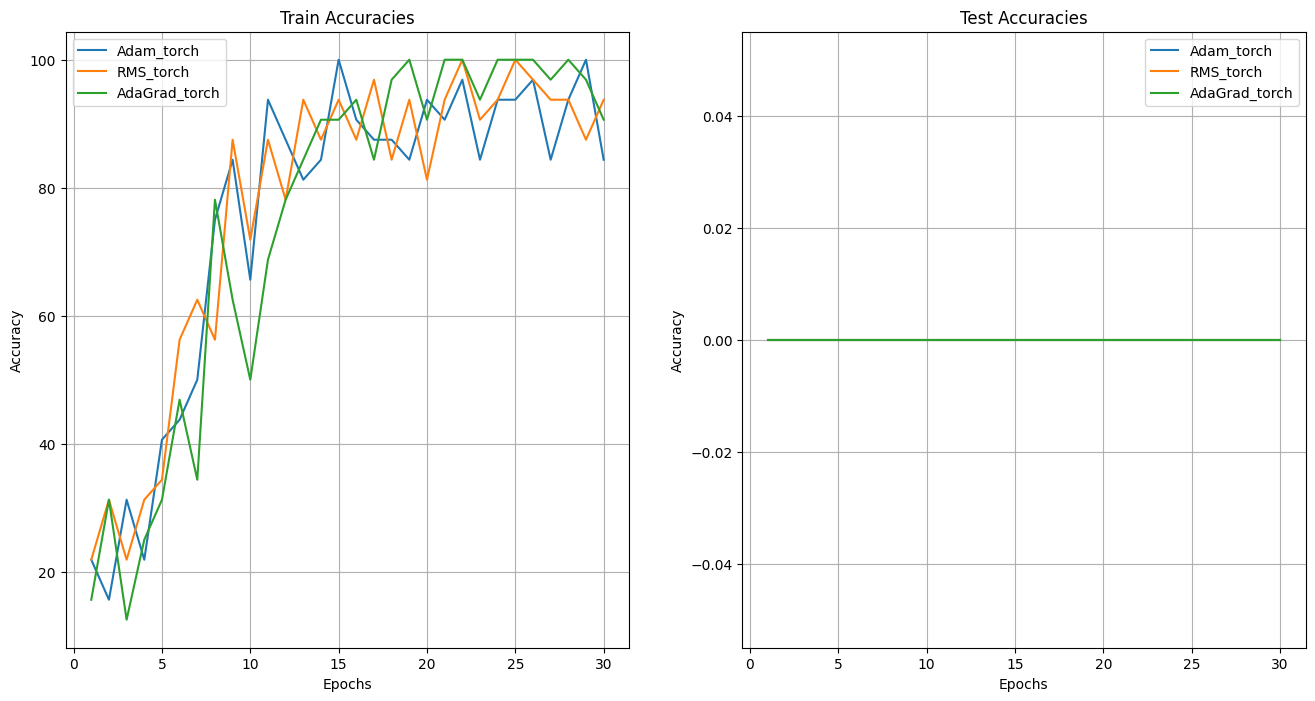

In [13]:
trainer.plot_acc_graphs()